In [1]:
import tensorflow as tf
import pathlib
import PIL

In [2]:
batch_size = 32
img_height = 128
img_width = 128

In [3]:
import shutil
import os

In [4]:
bucket_destination_dir = pathlib.Path("./train_buckets") 
image_count = len(list(bucket_destination_dir.glob('*/*.jpg')))
print(image_count)

49308


A sample woman aging from 19 to 30:


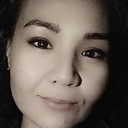

In [5]:
print("A sample woman aging from 19 to 30:")
zero = list(pathlib.Path(bucket_destination_dir).glob('0/*.jpg'))
PIL.Image.open(str(zero[1]))

A sample woman aging from 31 to 40:


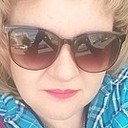

In [6]:
print("A sample woman aging from 31 to 40:")
one = list(pathlib.Path(bucket_destination_dir).glob('1/*.jpg'))
PIL.Image.open(str(one[1]))

A sample woman aging from 41 to 50:


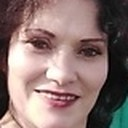

In [7]:
print("A sample woman aging from 41 to 50:")
two = list(pathlib.Path(bucket_destination_dir).glob('2/*.jpg'))
PIL.Image.open(str(two[2]))

A sample woman aging from 51 to 60:


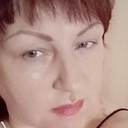

In [8]:
print("A sample woman aging from 51 to 60:")
three = list(pathlib.Path(bucket_destination_dir).glob('3/*.jpg'))
PIL.Image.open(str(three[1]))

A sample woman aging from 61 to 70:


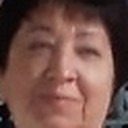

In [9]:
print("A sample woman aging from 61 to 70:")
four = list(pathlib.Path(bucket_destination_dir).glob('4/*.jpg'))
PIL.Image.open(str(four[1]))

In [5]:
training_folder = bucket_destination_dir
# Load data using keras util

train_ds = tf.keras.utils.image_dataset_from_directory(
  training_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 49308 files belonging to 5 classes.
Using 39447 files for training.


2022-12-05 19:43:19.398069: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-05 19:43:19.398509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-84-80.us-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-05 19:43:19.403785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 49308 files belonging to 5 classes.
Using 9861 files for validation.


In [7]:
num_classes = 5

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

keras.backend.set_image_data_format('channels_last')

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

2022-12-05 19:43:44.416133: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2022-12-05 19:43:44.623956: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2022-12-05 19:43:44.749184: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


Choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                        

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1233/1233 [==============================] - 2947s 2s/step - loss: 1.4461 - accuracy: 0.3781 - val_loss: 1.3287 - val_accuracy: 0.4109
Epoch 2/10
1233/1233 [==============================] - 2966s 2s/step - loss: 1.2990 - accuracy: 0.4274 - val_loss: 1.3297 - val_accuracy: 0.4068
Epoch 3/10
1233/1233 [==============================] - 2925s 2s/step - loss: 1.1808 - accuracy: 0.4860 - val_loss: 1.4081 - val_accuracy: 0.3823
Epoch 4/10
1233/1233 [==============================] - 2928s 2s/step - loss: 0.9323 - accuracy: 0.6086 - val_loss: 1.8048 - val_accuracy: 0.3757
Epoch 5/10
1233/1233 [==============================] - 2926s 2s/step - loss: 0.6570 - accuracy: 0.7324 - val_loss: 2.7788 - val_accuracy: 0.3564
Epoch 6/10
1233/1233 [==============================] - 2987s 2s/step - loss: 0.4477 - accuracy: 0.8251 - val_loss: 3.5907 - val_accuracy: 0.3476
Epoch 7/10
1233/1233 [==============================] - 2946s 2s/step - loss: 0.3267 - accuracy: 0.8771 - val_loss: 4.3719 -

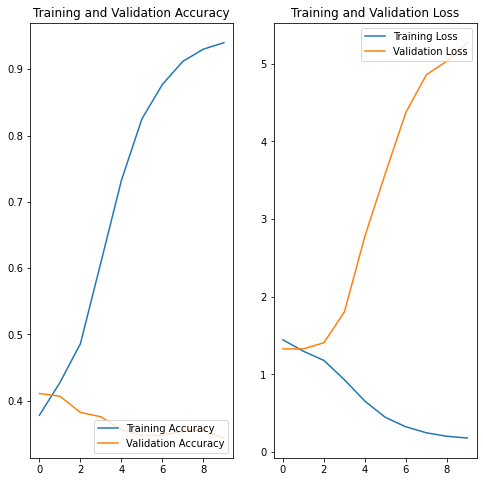

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(128,
                                  128,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [12]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1233/1233 [==============================] - 675s 546ms/step - loss: 1.4170 - accuracy: 0.3427 - val_loss: 1.3817 - val_accuracy: 0.3733
Epoch 2/15
1233/1233 [==============================] - 676s 548ms/step - loss: 1.3765 - accuracy: 0.3721 - val_loss: 1.3376 - val_accuracy: 0.3977
Epoch 3/15
1233/1233 [==============================] - 678s 550ms/step - loss: 1.3517 - accuracy: 0.3906 - val_loss: 1.3249 - val_accuracy: 0.4025
Epoch 4/15
1233/1233 [==============================] - 681s 552ms/step - loss: 1.3326 - accuracy: 0.4013 - val_loss: 1.3013 - val_accuracy: 0.4204
Epoch 5/15
1233/1233 [==============================] - 664s 538ms/step - loss: 1.3151 - accuracy: 0.4132 - val_loss: 1.2947 - val_accuracy: 0.4257
Epoch 6/15
1233/1233 [==============================] - 651s 528ms/step - loss: 1.2997 - accuracy: 0.4247 - val_loss: 1.2784 - val_accuracy: 0.4373
Epoch 7/15
1233/1233 [==============================] - 648s 525ms/step - loss: 1.2892 - accuracy: 0.4288 - val_

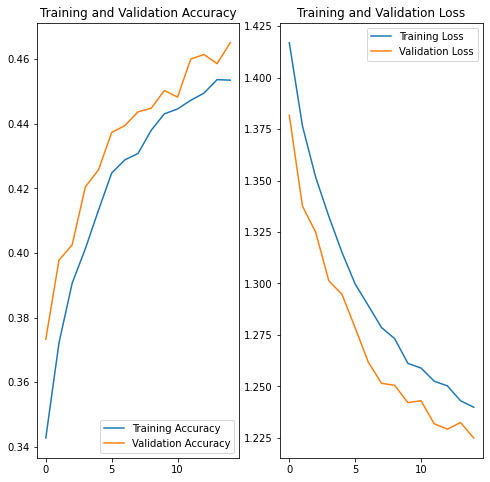

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


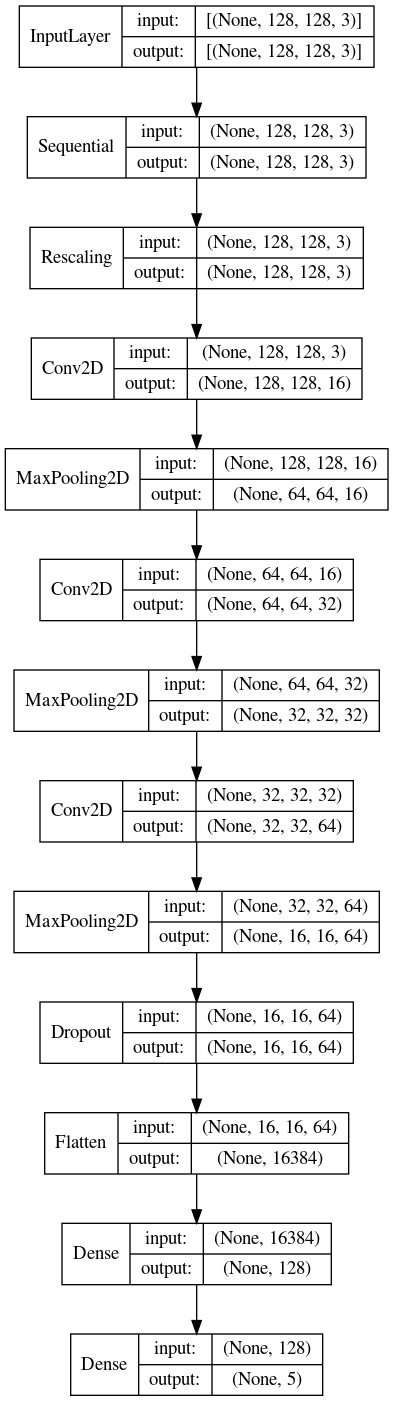

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False)